# 3DRDNN

Main pipeline for research in my Master.

## goals in this notebook

Prepare the pipeline for any 3d DNN to train on CT data.
1) data loader
2) DNN
3) Training
4) Results comparison

In [1]:
# Testing reading GPU
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please ensure you have installed TensorFlow correctly')
else:
    print(tf.test.gpu_device_name())

TensorFlow Version: 2.10.1
/device:GPU:0


In [2]:
# datasets for tf
from data_preprocessing import get_dataset_large

batch_size = 32
dataset = get_dataset_large(
    "C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords_2D\\train\\"
)

dataset = dataset.shuffle(37008).batch(batch_size)
valid_dataset = get_dataset_large(
    "C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords_2D\\valid\\")
valid_dataset = valid_dataset.batch(
    batch_size
)

for sample in dataset.take(1):
    print(sample[0].shape)
    print(sample[1].shape)

for sample in valid_dataset.take(2):
    print(sample[0].shape)
    print(sample[1].shape)
    print(np.min(sample[0]))
    print(np.max(sample[0]))

print(dataset)
print(valid_dataset)

initalised with path data\LITS_Challenge\train
files: 50,50
initalised with path data\LITS_Challenge\valid
files: 15,15
['C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords_2D\\train\\images0.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords_2D\\train\\images1.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords_2D\\train\\images10.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords_2D\\train\\images11.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords_2D\\train\\images12.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords_2D\\train\\images13.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords_2D\\train\\images14.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords_2D\\train\\images2.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\LITS_TFRecords_2D\\train\\images3.tfrecords', 'C:\\Users\\kaczm\\programming\\3DRDNN\\data\\

In [3]:
# Network set-up
from utils import models

model = models.model_call(model_name="2DUNET",px=256,features=16)

In [4]:
# Metrics and training
 
adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
precision = tf.keras.metrics.Precision(
    thresholds=0.5)
recall = tf.keras.metrics.Recall(
    thresholds=0.5)

model.compile(loss="binary_crossentropy", optimizer=adam, metrics=[precision,recall])
model.summary(positions=[.33, .66, .78, 1.])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape                    Param #     Connected to          
 input_1 (InputLayer)           [(None, 256, 256, 1)]           0           []                    
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16)            160         ['input_1[0][0]']     
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16)            2320        ['conv2d[0][0]']      
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 128, 128, 16)            0           ['conv2d_1[0][0]']    
                                                                                              

                                                                            ][0]',                
                                                                             'conv2d_5[0][0]']    
                                                                                                  
 dropout_5 (Dropout)            (None, 64, 64, 128)             0           ['concatenate_1[0][0]'
                                                                            ]                     
                                                                                                  
 conv2d_12 (Conv2D)             (None, 64, 64, 64)              73792       ['dropout_5[0][0]']   
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 64, 64)              36928       ['conv2d_12[0][0]']   
                                                                                                  
 conv2d_tr

In [5]:
# Results
# reading checkpoint if needen
#
#################################

from tensorflow.keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
    TerminateOnNaN,
)


#model.load_weights("models\\2DUNET_lesion_16_256\\epoch-30-valloss-0.1750-0.26-0.97.hdf5")

# training
callbacks = [
    # EarlyStopping(patience=10, verbose=1),
    #ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.0000001, verbose=1),
    ModelCheckpoint(
        "models\\2DUNET_lesion_16_256\\epoch-{epoch:02d}-valloss-{val_loss:.4f}-{val_precision:.2f}-{val_recall:.2f}.hdf5",
        verbose=1,
        save_best_only=False,
        save_weights_only=False,
    ),
    TerminateOnNaN(),
]
epochs = 60

history = model.fit(
    dataset,
    validation_data=valid_dataset,
    callbacks=callbacks,
    initial_epoch=50,
    epochs=epochs,
)

Epoch 31/50
    938/Unknown - 296s 239ms/step - loss: 0.0102 - precision: 0.9193 - recall: 0.8970
Epoch 31: saving model to models\2DUNET_lesion_16_256\epoch-31-valloss-0.1604-0.28-0.96.hdf5
938/938 [==============================] - 322s 266ms/step - loss: 0.0102 - precision: 0.9193 - recall: 0.8970 - val_loss: 0.1604 - val_precision: 0.2803 - val_recall: 0.9649
Epoch 32/50
938/938 [==============================] - ETA: 0s - loss: 0.0098 - precision: 0.9219 - recall: 0.9030
Epoch 32: saving model to models\2DUNET_lesion_16_256\epoch-32-valloss-0.1384-0.31-0.95.hdf5
938/938 [==============================] - 299s 268ms/step - loss: 0.0098 - precision: 0.9219 - recall: 0.9030 - val_loss: 0.1384 - val_precision: 0.3110 - val_recall: 0.9546
Epoch 33/50
938/938 [==============================] - ETA: 0s - loss: 0.0093 - precision: 0.9250 - recall: 0.9084
Epoch 33: saving model to models\2DUNET_lesion_16_256\epoch-33-valloss-0.1237-0.34-0.96.hdf5
938/938 [==============================] - 

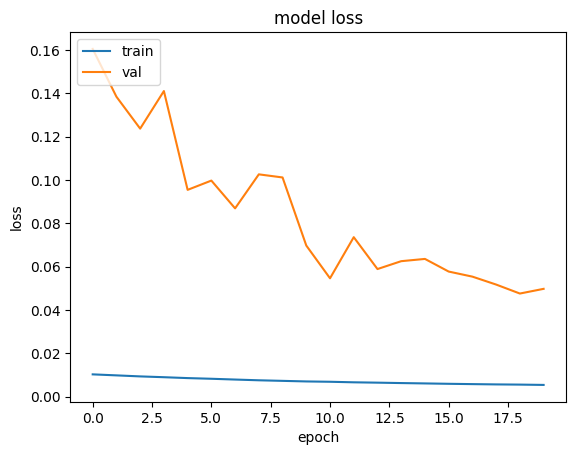

INFO:tensorflow:Assets written to: ram://1d300b1b-9a0a-4568-9899-38cb3094290f/assets


INFO:tensorflow:Assets written to: ram://1d300b1b-9a0a-4568-9899-38cb3094290f/assets


In [6]:


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

np.save("2Dunet_history_lesion_50_70.npy",np.array(history))



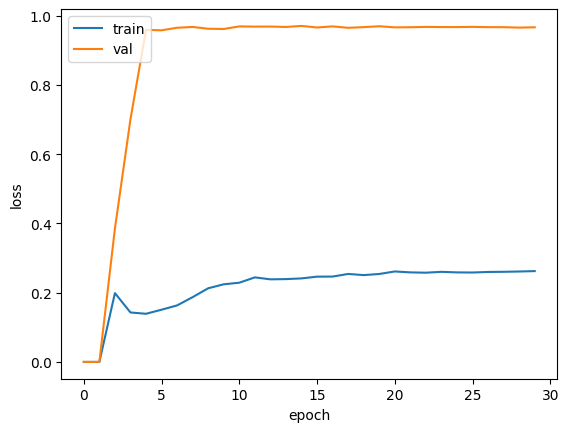

In [7]:
#a zrób testowy trening od modelu do wątroby :))) mnoże będzie lepiej!

plt.plot(history.history['val_precision'])
plt.plot(history.history['val_recall'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
new_model = models.model_call(model_name="2DUNET",px=256,features=16)

new_model.load_weights("models\\2DUNET_lesion_16_256\\epoch-30-valloss-0.1750-0.26-0.97.hdf5")
threshold = 0.99


adam = tf.keras.optimizers.Adam(
    learning_rate=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam')
precision = tf.keras.metrics.Precision(
    thresholds=threshold)
recall = tf.keras.metrics.Recall(
    thresholds=threshold)

new_model.compile(loss="binary_crossentropy", optimizer=adam, metrics=[precision,recall])



new_model.evaluate(valid_dataset)

263/263 [==============================] - 24s 90ms/step - loss: 0.1750 - precision_5: 0.6134 - recall_5: 0.7025


[0.1749546378850937, 0.6133501529693604, 0.702461302280426]

In [ ]:



n_max = 700
n=0
for x in loader_valid.data_generator_2d_lesion():
   if n < 100:
      pass
   elif n < n_max:
      plt.subplot(1,3,1)
      plt.imshow(x[0])
      plt.subplot(1,3,2)
      preds = new_model.predict(tf.reshape(x[0],[1,256,256,1]))
      plt.imshow(preds[0,:,:,1])
      plt.subplot(1,3,3)
      plt.imshow(x[1][:,:,1])
      plt.show()
   else:
      break
   n+=1